###Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


###Importing Libraries

In [0]:
import os
import cv2
import random

import pandas as pd
import numpy as np

from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 

import tensorflow as tf
import keras
import keras.backend as K
import keras.layers
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, concatenate, BatchNormalization, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import skimage
from skimage.io import imread
from skimage.transform import resize
from sklearn.utils import shuffle

import imgaug as aug
import imgaug.augmenters as img_aug

import tqdm

###Clear The model

In [0]:
tf.reset_default_graph()
K.clear_session()

##Data Analysis

In [0]:
#Get all The images in the Normal Directory
train_normal =  Path("../content/drive/My Drive/Colab Notebooks/chest_xray/train/NORMAL/").glob('*.jpeg')

#Get all the images in the Pneumonia Directory
train_pneumonia =  Path("../content/drive/My Drive/Colab Notebooks/chest_xray/train/PNEUMONIA/").glob('*.jpeg')


In [0]:
#Create list to contain all images, as well as their labels
train_images = []

In [0]:
#Appending Normal Images to list, with label = 0
for img in train_normal:
    train_images.append((img,0))

In [0]:
#Appending Pneumonia Images to list, with label = 1
#Use counter to split the data equally, benchmarked with the number of Normal images
i=0
for img in train_pneumonia:
    train_images.append((img,1))
    i=i+1
    if i == 1341:
      break

In [0]:
#Shuffling the data    
random.shuffle(train_images)

#create a datframe with columns xray and label
train_images = pd.DataFrame(train_images, columns=['xray', 'label'],index=None)

In [15]:
#Display top 5 
train_images.head()

,xray,label
0,../content/drive/My Drive/Colab Notebooks/ches...,0
1,../content/drive/My Drive/Colab Notebooks/ches...,1
2,../content/drive/My Drive/Colab Notebooks/ches...,0
3,../content/drive/My Drive/Colab Notebooks/ches...,0
4,../content/drive/My Drive/Colab Notebooks/ches...,1


In [16]:
#Check if data is split equally
train_images['label'].value_counts()

1    1341
0    1341
Name: label, dtype: int64

##Train/Validation split (90%/10%) 
###Total samples 2682
###Validation Samples(10% of 2682) = 268 

In [0]:
valid_data = (train_images).iloc[:268]

In [18]:
valid_data['label'].value_counts()

0    146
1    122
Name: label, dtype: int64

In [0]:
train_data = (train_images).iloc[268:]

In [20]:
train_data['label'].value_counts()

1    1219
0    1195
Name: label, dtype: int64

1    1219
0    1195
Name: label, dtype: int64
Percentages :
1    50.4971
0    49.5029
Name: label, dtype: float64


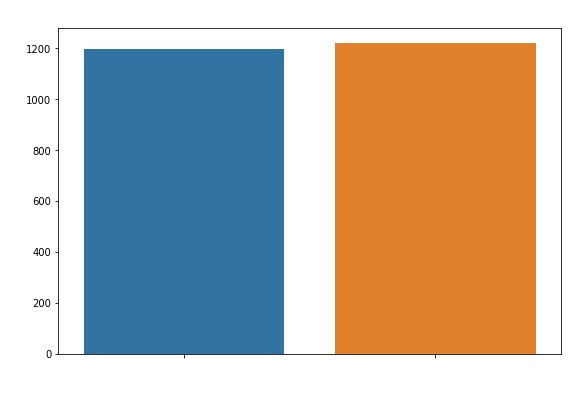

In [21]:
data_split = train_data['label'].value_counts()
print(data_split)
print("Percentages :")
print(100. * train_data.label.value_counts() / len(train_data.label))

plt.figure(figsize=(9,6))
sns.barplot(x=data_split.index, y=data_split.values)
plt.title('Data Split', fontsize = 20, color='white')
plt.xlabel('Type', fontsize =15, color='white')
plt.ylabel('Number of Images',fontsize =15, color='white')
plt.xticks(range(len(data_split.index)), ["Normal", "Pneumonia"],fontsize = 15, color='white')
plt.show()

#Creating Custom Generator
###We will create two different image generators, one for validation and the other for training samples
###Data Augmentation will only be applied to training samples

#Validation Image Generator

In [22]:
normal_xray = valid_data[valid_data['label']==0]
pneumonia_xray = valid_data[valid_data['label']==1]
print('Normal Validation Samples {}'.format(normal_xray['label'].value_counts()))
print('Pneumonia Validation Samples {}'.format(pneumonia_xray['label'].value_counts()))

Normal Validation Samples 0    146
Name: label, dtype: int64
Pneumonia Validation Samples 1    122
Name: label, dtype: int64


In [0]:
#Two lists, one containing images and the other containing labels
val_img = []
val_lab = []

In [0]:
#For Normal Samples
for index, row in normal_xray.iterrows():
#Read in image    
    img = cv2.imread(str(row['xray']))
#Resize   
    img = cv2.resize(img, (224,224))
#To RGB since CV2 reads in BGR mode  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#Normalize Pixels  
    img = img.astype(np.float32)/255.
# To categorical [1,0] - [0,1]
    label = to_categorical(0, num_classes=2)
#Append to lists 
    val_img.append(img)
    val_lab.append(label)

In [0]:
#For Pneumonia Samples
for index, row in pneumonia_xray.iterrows():
#Read in image    
    img = cv2.imread(str(row['xray']))
#Resize
    img = cv2.resize(img, (224,224))
#To RGB since CV2 reads in BGR mode  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#Normalize Pixels  
    img = img.astype(np.float32)/255.
# To categorical [1,0] - [0,1]
    label = to_categorical(1, num_classes=2)
#Append to lists
    val_img.append(img)
    val_lab.append(label)

In [27]:
# Converting the lists into numpy arrays
val_img = np.array(val_img)
val_lab = np.array(val_lab)
print("Total number of validation examples: ", val_img.shape)
print("Total number of labels:", val_lab.shape)

Total number of validation examples:  (268, 224, 224, 3)
Total number of labels: (268, 2)


#Data Augmentation
###Applied on training samples only

In [0]:
# Augmentation sequence 
# Only on of the augmentation techniques below will be applied to one sample at random
augment = img_aug.OneOf([
    #scale to 80-120% of image height/width (each axis independently)
    img_aug.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),
    #Gaussian blue (sigma of 1)
    img_aug.GaussianBlur(sigma=1),
    # Strengthen or weaken the contrast in each image.
    img_aug.ContrastNormalization((0.75, 1.5)),
    #random brightness
    img_aug.Multiply((1.2, 1.5))]) 

#Training Samples Custom Generator

In [0]:
"""""""""
From Nilesh
Found @: https://medium.com/@ensembledme/writing-custom-keras-generators-fe815d992c5a

"""""""""
def train_gen(train, batch_size):
    i =0
    training_size = len(train)
    train_steps = training_size//batch_size
    batch_data = np.zeros((batch_size, 224,224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)
    points = np.arange(training_size)
    while True:
        np.random.shuffle(points)
        counter = 0
        next_batch = points[(i*batch_size):(i+1)*batch_size]
        for j, index in enumerate(next_batch):
          #Get all images
            patient_img = train.iloc[index]['xray']
          #Get all labels
            label = train.iloc[index]['label'] 
          #To categorical
            label_categorical = to_categorical(label, num_classes=2)
          #Read in
            img = cv2.imread(str(patient_img))
            img = cv2.resize(img, (224,224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.            
            batch_data[counter] = img
            batch_labels[counter] = label_categorical           
            # Only augment of Normal samples as they are undersampled
            if label==0 and counter < batch_size-2:
                aug_img1 = augment.augment_image(img)
                aug_img2 = augment.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.
                batch_data[counter+1] = aug_img1
                batch_labels[counter+1] = label_categorical
                batch_data[counter+2] = aug_img2
                batch_labels[counter+2] = label_categorical
                counter +=2            
            else:
              counter+=1           
            if counter==batch_size-1:
                break            
        i+=1
        yield batch_data, batch_labels            
        if i>=train_steps:
            i=0

#Create Model

###Using Transfer Learning
* Fine tune the model

###VGG 16

In [0]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

base =VGG16(weights=None,include_top=False, input_shape=(224,224,3))

x =base.output

x =GlobalMaxPooling2D()(x)

#Adding three dense layers to learn more complex functions
#elu activation -> relu activation -> relu activation
x =Dense(1024,activation='elu')(x)

x =Dense(1024,activation='relu')(x)

x =Dense(512,activation='relu')(x) 

#Last layer(softmax activation)
preds =Dense(2,activation='softmax')(x) 


model =Model(inputs=base.input,outputs=preds)

###Freezing the first 6 layers of the model

In [0]:
for layer in model.layers[:6]:
    layer.trainable=False
for layer in model.layers[6:]:
    layer.trainable=True

In [124]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
def model_plots(history):
    
    plt.plot(fitting.history['acc'])
    plt.plot(fitting.history['val_acc'])
    plt.title('Model accuracy', color = 'white')
    plt.ylabel('Accuracy',  color = 'white')
    plt.xlabel('Epoch',  color = 'white')
    plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(fitting.history['loss'])
    plt.plot(fitting.history['val_loss'])
    plt.title('Model loss', color = 'white')
    plt.ylabel('Loss', color = 'white')
    plt.xlabel('Epoch', color = 'white')
    plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
    plt.show()

In [0]:
# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size
nb_valid_steps = val_img.shape[0]//batch_size
print("Number of training steps is:  {}   Number of validation steps is:  {}".format(nb_train_steps, nb_valid_steps))
print(train_data.shape[0])
print(batch_size)
#print(train_data_gen)
print(train_data.shape[0]//batch_size)

In [0]:
#stop training if no improvements are seen
#Patience of 4
early_stop = EarlyStopping(monitor="val_loss",
		                           mode="min",
		                           patience=4,
		                           restore_best_weights=True)

#reduce Learning rate if no imporovement within 2 ephocs
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                                  patience=2,
                                  verbose=1,
                                  factor=0.5,
                                  min_lr=0.0000001)

# saves best model weights to file
checkpoint = ModelCheckpoint('../drive/My Drive/Colab Notebooks/chest_xray/Best',
		                             monitor='val_loss',
		                             verbose=1,
		                             save_best_only=True,
		                             mode='min',
		                             save_weights_only=True)

In [0]:
batch_size = 16
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer= RMSprop(lr=0.00001, decay=1e-6))

In [0]:
fitting = model.fit_generator(train_gen(train_data, batch_size), 
                              epochs=14, verbose=1,
                              steps_per_epoch=train_data.shape[0]//batch_size, 
                              validation_data= (val_img,val_lab),
                              validation_steps=val_img.shape[0]//batch_size,
                              callbacks=[early_stop,lr_reduce],
                              class_weight={0:1.0, 1:0.4})

In [0]:
model_plots(fitting)

#Load Best Performing Model Weights

In [0]:
#Load The model Weights
model.load_weights("../content/drive/My Drive/Colab Notebooks/chest_xray/VGG16-94Recall.h5")

#Evalute Model on test samples

###Analyse test data

In [0]:
#Get all The images in the Test Normal Directory
test_normal =  Path("../content/drive/My Drive/Colab Notebooks/chest_xray/test/NORMAL/").glob('*.jpeg')

#Get all the images in the TestPneumonia Directory
test_pneumonia =  Path("../content/drive/My Drive/Colab Notebooks/chest_xray/test/PNEUMONIA/").glob('*.jpeg')

In [0]:
#Create list to contain all images, as well as their labels
test_images = []

In [0]:
#Appending Normal Images to list, with label = 0
for img in test_normal:
    test_images.append((img,0))
    
#Appending Pneumonia Images to list, with label = 1
for img in test_pneumonia:
    test_images.append((img,1))

In [0]:
#Shuffling the data    
random.shuffle(test_images)

#create a datframe with columns xray and label
test_images = pd.DataFrame(test_images, columns=['xray', 'label'],index=None)

In [52]:
print(test_images['label'].value_counts())
test_images.head()

1    390
0    234
Name: label, dtype: int64


,xray,label
0,../content/drive/My Drive/Colab Notebooks/ches...,1
1,../content/drive/My Drive/Colab Notebooks/ches...,1
2,../content/drive/My Drive/Colab Notebooks/ches...,1
3,../content/drive/My Drive/Colab Notebooks/ches...,0
4,../content/drive/My Drive/Colab Notebooks/ches...,1


##Create Test Data generator

In [54]:
normal_test = test_images[test_images['label']==0]
pneumonia_test = test_images[test_images['label']==1]
print('Normal Test Samples {}'.format(normal_test['label'].value_counts()))
print('Pneumonia Test Samples {}'.format(pneumonia_test['label'].value_counts()))

Normal Test Samples 0    234
Name: label, dtype: int64
Pneumonia Test Samples 1    390
Name: label, dtype: int64


In [0]:
#Two lists, one containing images and the other containing labels
test_img = []
test_lab = []

In [0]:
#For Normal Test Samples
for index, row in normal_test.iterrows():
#Read in image    
    img = cv2.imread(str(row['xray']))
#Resize   
    img = cv2.resize(img, (224,224))
#To RGB since CV2 reads in BGR mode  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#Normalize Pixels  
    img = img.astype(np.float32)/255.
# To categorical [1,0] - [0,1]
    label = to_categorical(0, num_classes=2)
#Append to lists 
    test_img.append(img)
    test_lab.append(label)

In [0]:
#For Pneumonia test Samples
for index, row in pneumonia_test.iterrows():
#Read in image    
    img = cv2.imread(str(row['xray']))
#Resize
    img = cv2.resize(img, (224,224))
#To RGB since CV2 reads in BGR mode  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#Normalize Pixels  
    img = img.astype(np.float32)/255.
# To categorical [1,0] - [0,1]
    label = to_categorical(1, num_classes=2)
#Append to lists
    test_img.append(img)
    test_lab.append(label)

In [58]:
# Converting the lists into numpy arrays
test_img = np.array(test_img)
test_lab = np.array(test_lab)
print("Total number of test examples: ", test_img.shape)
print("Total number of labels:", test_lab.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


##Evaluate the model on Test samples

In [140]:
t_loss, t_score = model.evaluate(test_img, test_lab, batch_size=16)

print("Accuracy on test samples: ", t_score)
print("Loss on test samples: ", t_loss)

624/624 [==============================] - 6s 10ms/step
Accuracy on test samples:  0.9230769230769231
Loss on test samples:  0.25891053284972143


#Results Analysis
* Confusion Matrix
* Precision
* Recall
* F1 Score
* ROC Curve

In [141]:
predictions = model.predict(test_img, batch_size=16)
predictions = np.argmax(predictions, axis=-1)

# Actual labels
orig_test_labels = np.argmax(test_lab, axis=-1)

print(orig_test_labels.shape)
print(predictions.shape)

(624,)
(624,)


##Confusion Matrix

<Figure size 432x288 with 0 Axes>

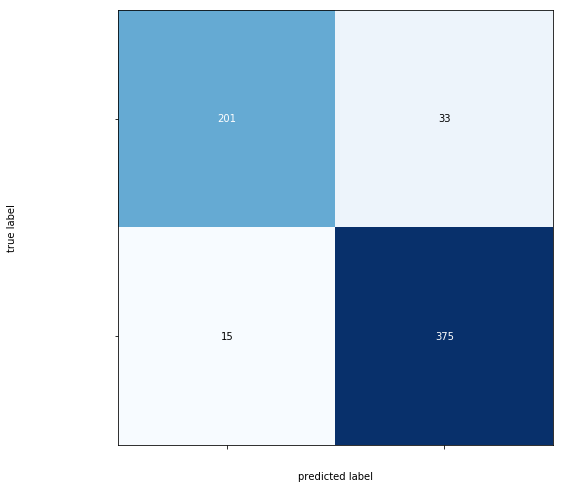

In [142]:
conf_matrix  = confusion_matrix(orig_test_labels, predictions)
plt.figure()
plot_confusion_matrix(conf_matrix,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16,color ='white')
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16,color ='white')
plt.show()

##Precision, Recall and F1 Score

In [143]:
true_neg, false_pos, false_neg, true_pos = conf_matrix.ravel()

precision = true_pos/(true_pos+false_pos)
recall = true_pos/(true_pos+false_neg)
f1_score= (2*precision*recall)/(precision+recall)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("f1_score of the model is {:.2f}".format(f1_score))

Recall of the model is 0.96
Precision of the model is 0.92
f1_score of the model is 0.94


##ROC Curve

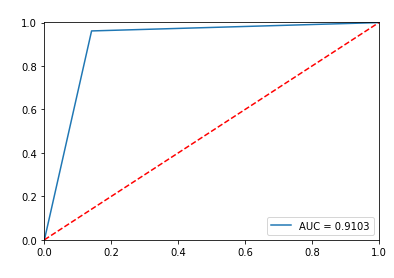

In [144]:
from sklearn.metrics import (precision_recall_curve, auc, roc_curve,
                             recall_score,
                             classification_report,
                             f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(orig_test_labels,predictions)
roc_auc = auc(fpr, tpr)

plt.title('ROC', color='white')
plt.plot(fpr,tpr,label='AUC = %0.4f'%roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001,1])
plt.ylim([0, 1.001])
plt.ylabel('True Pos Rate', color='white')
plt.xlabel('Flase Pos Rate', color='white')
plt.show()

##Upload X_Ray for prediction

In [72]:
from google.colab import files
from keras.preprocessing import image
p_list = []

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  pred_img = image.load_img(fn, target_size=(224,224))
  pred_img = image.img_to_array(pred_img)
  if pred_img.shape[2]==1:
    pred_img = np.dstack([pred_img, pred_img, pred_img])
  pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
  pred_img = pred_img.astype(np.float32)/255.
  p_list.append(pred_img)
  p_list= np.array(p_list)
  classes = model.predict(p_list, batch_size=16)
  classes= np.argmax(classes, axis=-1)
  if (classes ==1):
    print('pneumonia', classes)
  else:
    print(fn)
    print('normal',classes)

Saving h2.jpg to h2.jpg
h2.jpg
normal [0]
